In [26]:
# Hardware and user spercifications
import platform
import psutil
import getpass

# --- Setup: Imports ---
import os, seaborn as sns, sklearn, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim

# Scikit-learn imports
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.utils import shuffle

# Set a random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# --- Data Loading and Preprocessing ---

# Load the dataset
import sys
!{sys.executable} -m pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

In [2]:
# fetch dataset
phishing_websites = fetch_ucirepo(id=327)

# data (as pandas dataframes)
X = phishing_websites.data.features
Y = phishing_websites.data.targets

X = X.select_dtypes(include=[np.number])

# Map target labels: -1 -> 0, 0 -> 1, 1 -> 2 (Pytorch's CrossEntropyLoss() does not accept negative targets)
Y = Y.replace({-1: 0, 0: 1, 1: 2})

# Split the data (80% train, 20% validation). Set random_state = random_seed.
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=random_seed)

# Convert to PyTorch Tensors
X_train_t = torch.tensor(X_train.values, dtype=torch.float32)
X_val_t = torch.tensor(X_val.values, dtype=torch.float32)
y_train_t = torch.tensor(Y_train.values, dtype=torch.long).view(-1)
y_val_t = torch.tensor(Y_val.values, dtype=torch.long).view(-1)

print(f"Training features shape: {X_train_t.shape}")
print(f"Validation features shape: {X_val_t.shape}")

Training features shape: torch.Size([8844, 30])
Validation features shape: torch.Size([2211, 30])


<div class="alert alert-success">
    <h3>Model #1</h3>
    Simple Neural Network Model with 2 hidden layers and no regularization
</div>

In [3]:
# --- Model Definition ---
class SimpleNNClassifier(nn.Module):
    def __init__(self):
        super(SimpleNNClassifier, self).__init__()
        self.fc1 = nn.Linear(30, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

input_features = X_train_t.shape[1]
print(f"Model will accept {input_features} input features.")
print("--- Model Class Defined ---")

def calculate_full_loss(model, criterion, X, y):
    """Helper function to calculate loss over an entire dataset."""
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        outputs = model(X)
        loss = criterion(outputs, y)
    model.train()  # Set model back to train mode
    return loss.item()


Model will accept 30 input features.
--- Model Class Defined ---


<div class="alert alert-success">
    <h3>Training Method #1</h3>
    Simplified minibatch SGD training where weights are updated once per iteration/epoch
</div>

In [4]:
def train_with_simplified_minibatch(model, criterion, optimizer, X_train, y_train, X_val, y_val,
                         num_iterations, batch_size, check_every):
    train_losses = []
    val_losses = []
    iterations = []

    for i in range(1, num_iterations + 1):

        # Pick one random sample batch
        rand_index = np.random.choice(X_train.shape[0], batch_size, replace=False)
        rand_X_batch = X_train[rand_index]
        rand_y_batch = y_train[rand_index].long().view(-1)

        # Predict
        optimizer.zero_grad()
        outputs = model(rand_X_batch)

        # Compute loss
        loss = criterion(outputs, rand_y_batch)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Check progress
        if i % check_every == 0:
            train_loss = calculate_full_loss(model, criterion, X_train, y_train)
            val_loss = calculate_full_loss(model, criterion, X_val, y_val)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            iterations.append(i)

            print(f"Iteration {i}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}")

    return train_losses, val_losses, iterations, model


# --- Set Hyperparameters ---
LEARNING_RATE = 0.01
NUM_ITERATIONS = 3000
BATCH_SIZE = 32
CHECK_EVERY = round(NUM_ITERATIONS / 10)

# --- Model Initialization ---
model1 = SimpleNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=LEARNING_RATE)  

# --- Run Minibatch Training ---
train_losses, val_losses, iterations, model1 = train_with_simplified_minibatch(
    model1, criterion, optimizer,
    X_train_t, y_train_t, X_val_t, y_val_t,
    NUM_ITERATIONS, BATCH_SIZE, CHECK_EVERY
)

Iteration 300: train loss = 0.6223, val loss = 0.6216
Iteration 600: train loss = 0.2813, val loss = 0.2823
Iteration 900: train loss = 0.2160, val loss = 0.2178
Iteration 1200: train loss = 0.1977, val loss = 0.2021
Iteration 1500: train loss = 0.1896, val loss = 0.1975
Iteration 1800: train loss = 0.1850, val loss = 0.1948
Iteration 2100: train loss = 0.1813, val loss = 0.1916
Iteration 2400: train loss = 0.1798, val loss = 0.1909
Iteration 2700: train loss = 0.1784, val loss = 0.1908
Iteration 3000: train loss = 0.1779, val loss = 0.1919


Plotting...


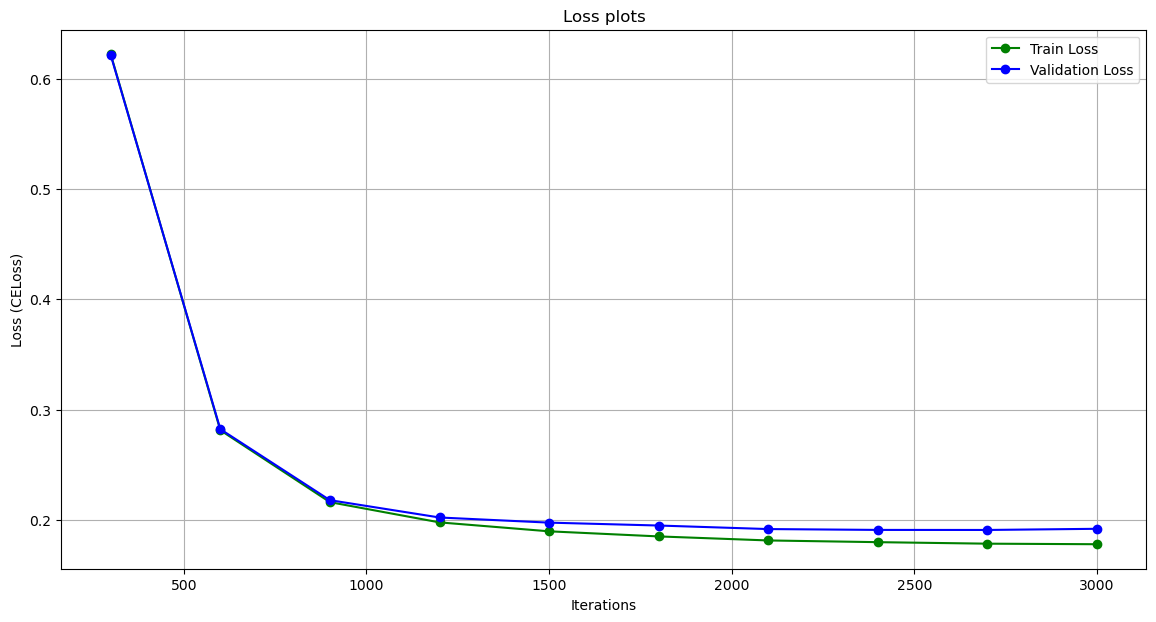

In [5]:
# --- Plotting ---
print("Plotting...")
plt.figure(figsize=(14, 7))

plt.plot(iterations, train_losses, label='Train Loss', linestyle='-', color='green', marker='o')
plt.plot(iterations, val_losses, label='Validation Loss', linestyle='-', color='blue', marker='o')

plt.title('Loss plots')
plt.xlabel('Iterations')
plt.ylabel('Loss (CELoss)')
plt.legend()
plt.grid(True)
plt.show()


Training Metrics:
Accuracy: 0.9316, Precision: 0.9308, Recall: 0.9308, F1-score: 0.9308


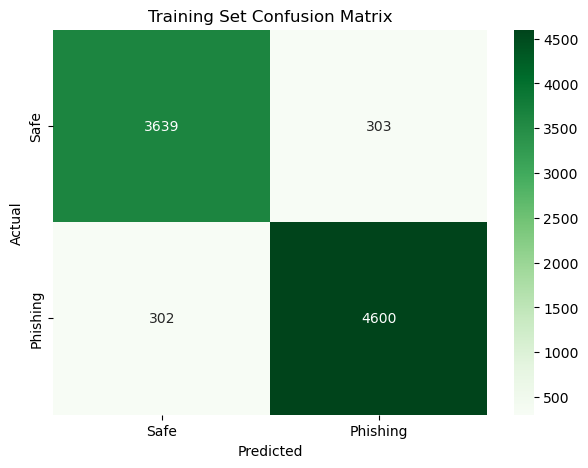

In [6]:
# --- Evaluate on training set ---
model1.eval()
with torch.no_grad():
    y_train_pred = torch.argmax(model1(X_train_t), dim=1)

# Map to readable labels
y_train_pred_label1 = ['Safe' if x==0 else 'Phishing' for x in y_train_pred.numpy()]
y_train_label1 = ['Safe' if x==0 else 'Phishing' for x in y_train_t.numpy()]

train_acc = accuracy_score(y_train_label1, y_train_pred_label1)
train_prec = precision_score(y_train_label1, y_train_pred_label1, average='macro')
train_rec = recall_score(y_train_label1, y_train_pred_label1, average='macro')
train_f1 = f1_score(y_train_label1, y_train_pred_label1, average='macro')

t1a = train_acc
t1p = train_prec
t1r = train_rec
t1f = train_f1

print(f"\nTraining Metrics:\nAccuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, F1-score: {train_f1:.4f}")

# --- Confusion Matrix for Training Set ---
cm_train = confusion_matrix(y_train_label1, y_train_pred_label1, labels=['Safe','Phishing'])
plt.figure(figsize=(7, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', xticklabels=['Safe','Phishing'], yticklabels=['Safe','Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training Set Confusion Matrix')
plt.show()


Validation Metrics:
Accuracy: 0.9236, Precision: 0.9218, Recall: 0.9227, F1-score: 0.9222


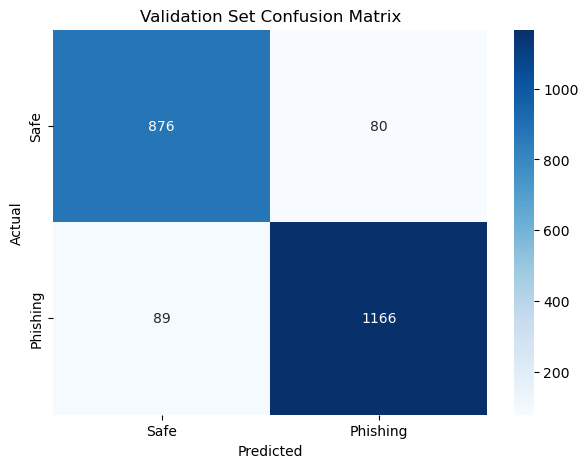

In [7]:
# --- Evaluate on validation set ---
model1.eval()
with torch.no_grad():
    y_val_pred = torch.argmax(model1(X_val_t), dim=1)

# Map to readable labels
y_val_pred_label1 = ['Safe' if x==0 else 'Phishing' for x in y_val_pred.numpy()]
y_val_label1 = ['Safe' if x==0 else 'Phishing' for x in y_val_t.numpy()]

# --- Calculate basic metrics ---
acc = accuracy_score(y_val_label1, y_val_pred_label1)
prec = precision_score(y_val_label1, y_val_pred_label1, average='macro')
rec = recall_score(y_val_label1, y_val_pred_label1, average='macro')
f1 = f1_score(y_val_label1, y_val_pred_label1, average='macro')

v1a = acc
v1p = prec
v1r = rec
v1f = acc


print(f"\nValidation Metrics:\nAccuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

# --- Confusion Matrix Heatmap ---
cm_val = confusion_matrix(y_val_label1, y_val_pred_label1, labels=['Safe','Phishing'])
plt.figure(figsize=(7, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Safe','Phishing'], yticklabels=['Safe','Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Set Confusion Matrix')
plt.show()

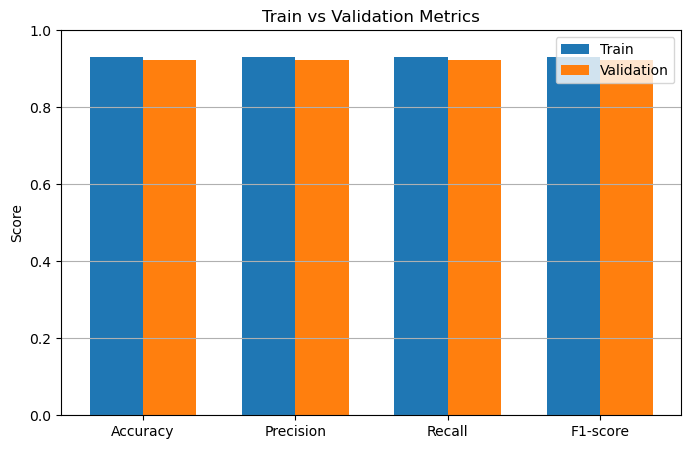

In [8]:
# --- Plot Train vs Validation metrics ---
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
train_values = [train_acc, train_prec, train_rec, train_f1]
val_values = [acc, prec, rec, f1]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, train_values, width, label='Train')
plt.bar(x + width/2, val_values, width, label='Validation')
plt.ylabel('Score')
plt.title('Train vs Validation Metrics')
plt.xticks(x, metrics)
plt.ylim(0,1)
plt.legend()
plt.grid(axis='y')
plt.show()

Number of suspicious (0) instances per feature:
 having_ip_address                0
url_length                     108
shortining_service               0
having_at_symbol                 0
double_slash_redirecting         0
prefix_suffix                    0
having_sub_domain             2891
sslfinal_state                 945
domain_registration_length       0
favicon                          0
port                             0
https_token                      0
request_url                      0
url_of_anchor                 4247
links_in_tags                 3545
sfh                            610
submitting_to_email              0
abnormal_url                     0
redirect                      7823
on_mouseover                     0
rightclick                       0
popupwindow                      0
iframe                           0
age_of_domain                    0
dnsrecord                        0
web_traffic                   2064
page_rank                        0
google

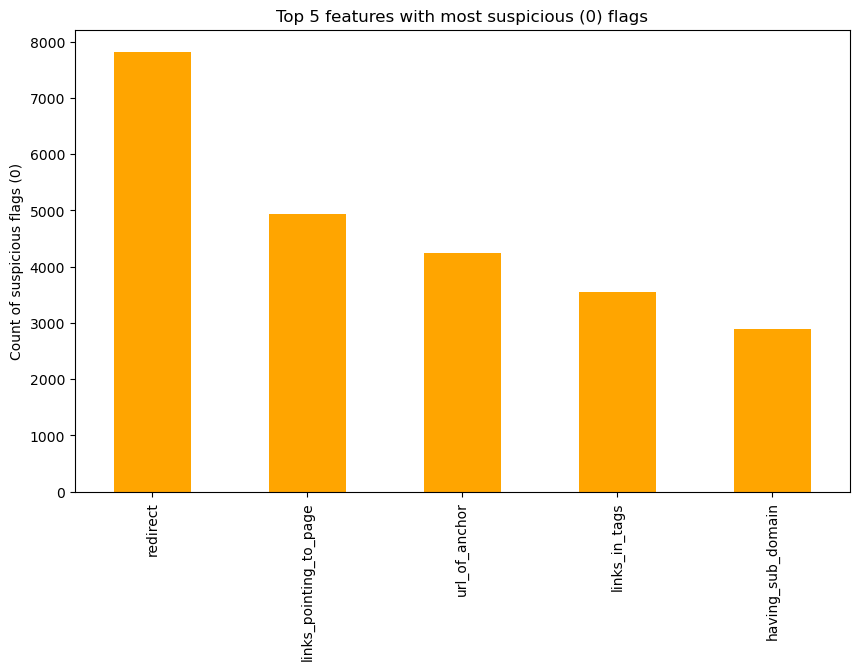

In [9]:
# Map Result back to readable labels
Y_label = Y.replace({-1: 'Safe', 1: 'Phishing', 0: 'Suspicious'})  # optional if 0 is used in target

# Features that indicate suspicion (0) per class
# Initialize a counter for each feature
suspicious_counts = pd.Series(0, index=X_train.columns)

# Traverse each row and each column
for idx, row in X_train.iterrows():
    for col in X_train.columns:
        if row[col] == 0:
            suspicious_counts[col] += 1

print("Number of suspicious (0) instances per feature:\n", suspicious_counts)

# Optional: Plot top 10 features with most suspicious flags
top_features = suspicious_counts.sort_values(ascending=False).head(5)
top_features.plot(kind='bar', figsize=(10,6), color='orange')
plt.title("Top 5 features with most suspicious (0) flags")
plt.ylabel("Count of suspicious flags (0)")
plt.show()

Mutual information of features with target:
 sslfinal_state                0.340341
url_of_anchor                 0.339055
having_sub_domain             0.087290
web_traffic                   0.084132
prefix_suffix                 0.079587
links_in_tags                 0.035161
request_url                   0.034315
domain_registration_length    0.032254
sfh                           0.020516
url_length                    0.010273
https_token                   0.009023
age_of_domain                 0.007181
having_ip_address             0.005827
statistical_report            0.005664
links_pointing_to_page        0.005349
rightclick                    0.005336
shortining_service            0.004289
dnsrecord                     0.004252
google_index                  0.004038
submitting_to_email           0.003940
double_slash_redirecting      0.003884
iframe                        0.003107
popupwindow                   0.001021
having_at_symbol              0.000000
favicon            

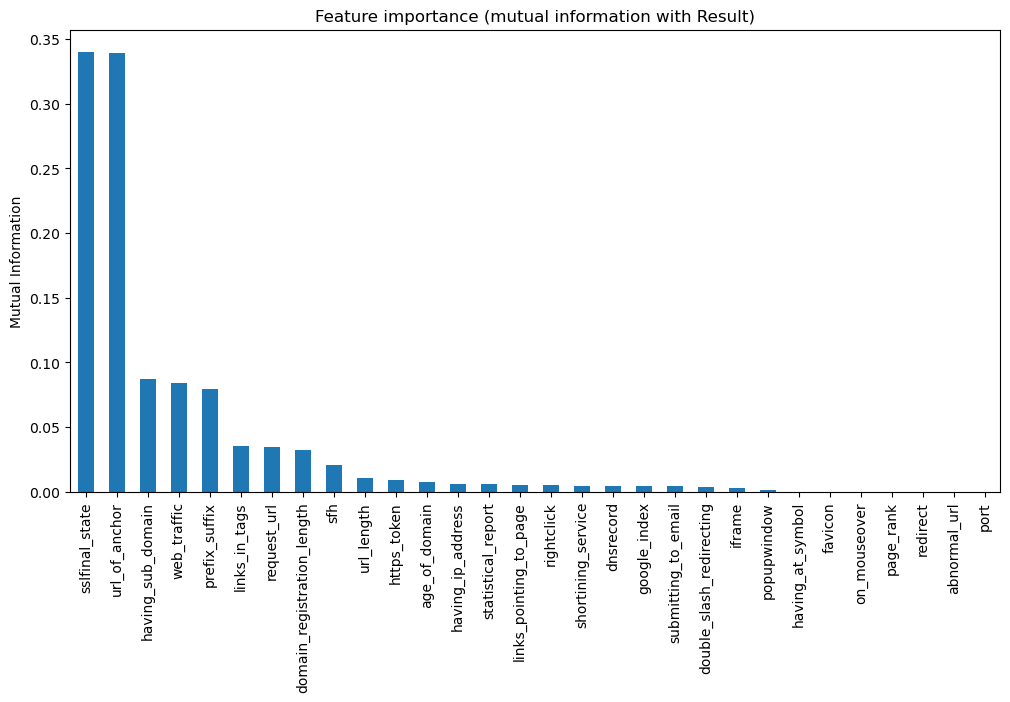

In [10]:
# Feature-class dependency using correlation
# Since features are discrete (-1,0,1) and target is categorical, use point biserial or mutual info
mi = mutual_info_classif(X_train, Y_train.values.ravel())
feature_mi = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("Mutual information of features with target:\n", feature_mi)

# Optional plot
feature_mi.plot(kind='bar', figsize=(12,6))
plt.title("Feature importance (mutual information with Result)")
plt.ylabel("Mutual Information")
plt.show()

<div class="alert alert-success">
    <h3>Model #2</h3>
    More advanced Neural Network Model consisting of 2 wider hidden layers with BatchNorms and Dropouts
</div>

In [11]:
# --- Model Definition ---
class BetterNNClassifier(nn.Module):
    def __init__(self, input_size = 30):
        super(BetterNNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(32)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

input_features = X_train_t.shape[1]
print(f"Model will accept {input_features} input features.")
print("--- Model Class Defined ---")

Model will accept 30 input features.
--- Model Class Defined ---


<div class="alert alert-success">
    <h3>Training Method #2</h3>
    Real (standard) minibatch SGD training where weights are updated (training data size / batch size) times per iteration/epoch, while adding L2 regularization
</div>

In [12]:
def train_with_minibatch(model, criterion, optimizer, X_train, y_train, X_val, y_val, num_epochs, batch_size, optimizer_name = "SGD"):
    train_losses, val_losses = [], []
    num_samples = X_train.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))
    print(f"\n--- {optimizer_name} ---\n")     
    for epoch in range(1, num_epochs + 1):
        # Shuffle the dataset 
        perm = torch.randperm(num_samples)
        X_train_shuffled = X_train[perm]
        y_train_shuffled = y_train[perm]

        for batch_idx in range(num_batches):
            # Pick random batch
            start = batch_idx * batch_size
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
   
            # Predict
            optimizer.zero_grad()
            outputs = model(X_batch)

            # Compute loss
            loss = criterion(outputs, y_batch)
            loss.backward()

            # Adjust learning weights
            optimizer.step()
            
        # Calculate the losses after each epoch
        train_loss = calculate_full_loss(model, criterion, X_train, y_train)
        val_loss = calculate_full_loss(model, criterion, X_val, y_val)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
         
        print(f"Epoch {epoch}: train loss = {train_loss:.4f}, val loss = {val_loss:.4f}")

    return train_losses, val_losses, model


# --- Set Hyperparameters ---
LEARNING_RATE = 0.03
NUM_EPOCHS = 30
BATCH_SIZE = 32

# --- Model Initialization ---
model2 = BetterNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=LEARNING_RATE, weight_decay=0.001) #L2 regularization 

# --- Run Minibatch Training ---
train_losses, val_losses, model2 = train_with_minibatch(
    model2, criterion, optimizer,
    X_train_t, y_train_t, X_val_t, y_val_t,
    NUM_EPOCHS, BATCH_SIZE
)


--- SGD ---

Epoch 1: train loss = 0.3457, val loss = 0.3617
Epoch 2: train loss = 0.1814, val loss = 0.1965
Epoch 3: train loss = 0.1649, val loss = 0.1827
Epoch 4: train loss = 0.1509, val loss = 0.1710
Epoch 5: train loss = 0.1449, val loss = 0.1619
Epoch 6: train loss = 0.1349, val loss = 0.1540
Epoch 7: train loss = 0.1358, val loss = 0.1565
Epoch 8: train loss = 0.1325, val loss = 0.1510
Epoch 9: train loss = 0.1249, val loss = 0.1421
Epoch 10: train loss = 0.1221, val loss = 0.1420
Epoch 11: train loss = 0.1251, val loss = 0.1430
Epoch 12: train loss = 0.1206, val loss = 0.1363
Epoch 13: train loss = 0.1159, val loss = 0.1346
Epoch 14: train loss = 0.1097, val loss = 0.1294
Epoch 15: train loss = 0.1118, val loss = 0.1315
Epoch 16: train loss = 0.1076, val loss = 0.1293
Epoch 17: train loss = 0.1032, val loss = 0.1238
Epoch 18: train loss = 0.1111, val loss = 0.1310
Epoch 19: train loss = 0.1067, val loss = 0.1311
Epoch 20: train loss = 0.1101, val loss = 0.1403
Epoch 21: train

30
Plotting...


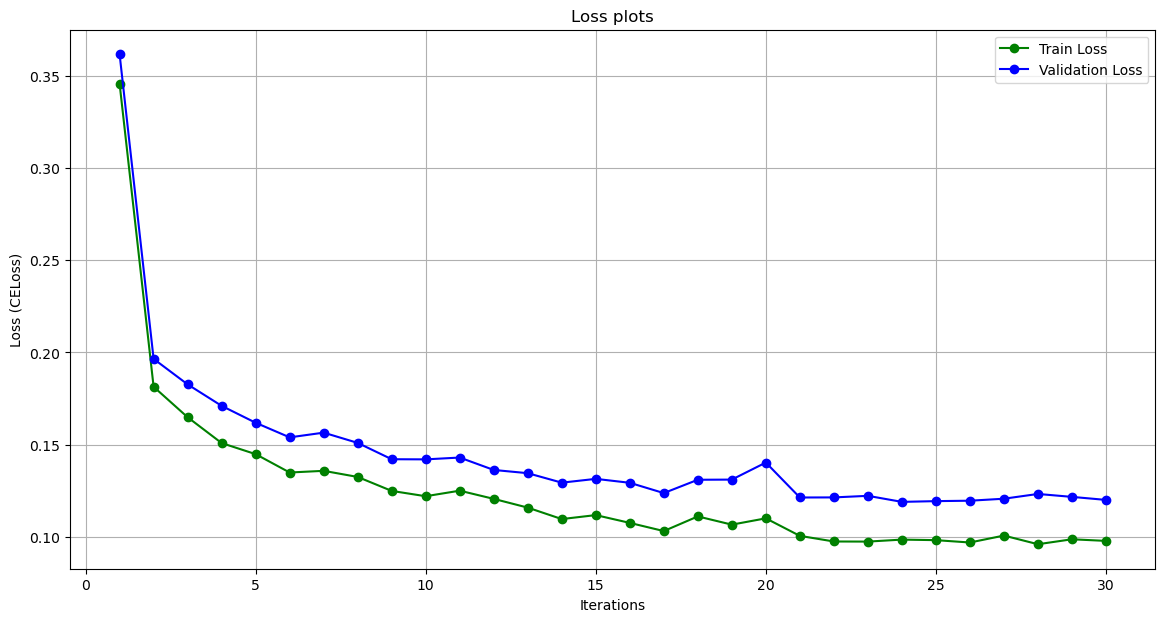

In [13]:
# --- Plotting ---
epochs = range(1, len(train_losses) + 1)
print(len(train_losses))

print("Plotting...")
plt.figure(figsize=(14, 7))

plt.plot(epochs, train_losses, label='Train Loss', linestyle='-', color='green', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', linestyle='-', color='blue', marker='o')

plt.title('Loss plots')
plt.xlabel('Iterations')
plt.ylabel('Loss (CELoss)')
plt.legend()
plt.grid(True)
plt.show()


Training Metrics:
Accuracy: 0.9626, Precision: 0.9615, Recall: 0.9631, F1-score: 0.9622


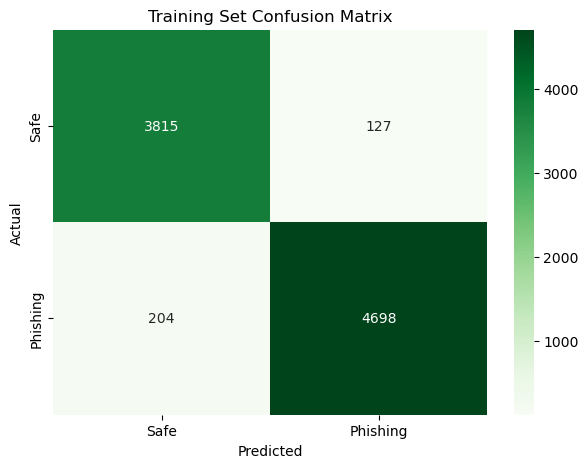

In [14]:
# --- Evaluate on training set ---
model2.eval()
with torch.no_grad():
    y_train_pred = torch.argmax(model2(X_train_t), dim=1)

# Map to readable labels
y_train_pred_label2 = ['Safe' if x==0 else 'Phishing' for x in y_train_pred.numpy()]
y_train_label2 = ['Safe' if x==0 else 'Phishing' for x in y_train_t.numpy()]

train_acc = accuracy_score(y_train_label2, y_train_pred_label2)
train_prec = precision_score(y_train_label2, y_train_pred_label2, average='macro')
train_rec = recall_score(y_train_label2, y_train_pred_label2, average='macro')
train_f1 = f1_score(y_train_label2, y_train_pred_label2, average='macro')

t2a = train_acc
t2p = train_prec
t2r = train_rec
t2f = train_f1

print(f"\nTraining Metrics:\nAccuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, F1-score: {train_f1:.4f}")

# --- Confusion Matrix for Training Set ---
cm_train = confusion_matrix(y_train_label2, y_train_pred_label2, labels=['Safe','Phishing'])
plt.figure(figsize=(7, 5))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', xticklabels=['Safe','Phishing'], yticklabels=['Safe','Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training Set Confusion Matrix')
plt.show()


Validation Metrics:
Accuracy: 0.9530, Precision: 0.9517, Recall: 0.9526, F1-score: 0.9521


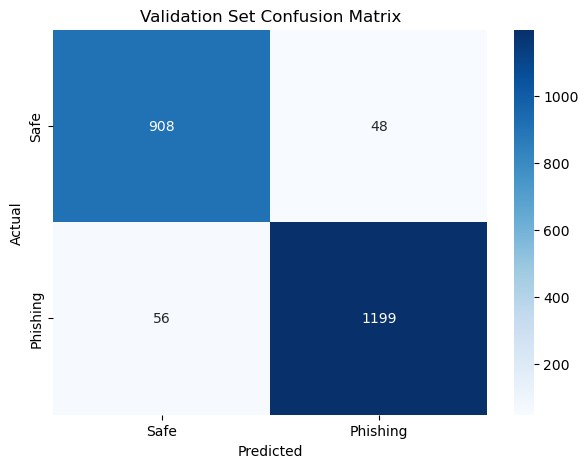

In [15]:
# --- Evaluate on validation set ---
model2.eval()
with torch.no_grad():
    y_val_pred = torch.argmax(model2(X_val_t), dim=1)

# Map to readable labels
y_val_pred_label2 = ['Safe' if x==0 else 'Phishing' for x in y_val_pred.numpy()]
y_val_label2 = ['Safe' if x==0 else 'Phishing' for x in y_val_t.numpy()]

# --- Calculate basic metrics ---
acc = accuracy_score(y_val_label2, y_val_pred_label2)
prec = precision_score(y_val_label2, y_val_pred_label2, average='macro')
rec = recall_score(y_val_label2, y_val_pred_label2, average='macro')
f1 = f1_score(y_val_label2, y_val_pred_label2, average='macro')

v2a = acc
v2p = prec
v2r = rec
v2f = f1

print(f"\nValidation Metrics:\nAccuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1:.4f}")

# --- Confusion Matrix Heatmap ---
cm_val = confusion_matrix(y_val_label2, y_val_pred_label2, labels=['Safe','Phishing'])
plt.figure(figsize=(7, 5))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=['Safe','Phishing'], yticklabels=['Safe','Phishing'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Validation Set Confusion Matrix')
plt.show()

Top 10 Most Important Features:
 url_of_anchor             0.814888
sslfinal_state            0.648319
redirect                  0.400000
having_sub_domain         0.301707
links_pointing_to_page    0.261967
web_traffic               0.253855
links_in_tags             0.243248
prefix_suffix             0.140307
sfh                       0.067358
request_url               0.060495
dtype: float64


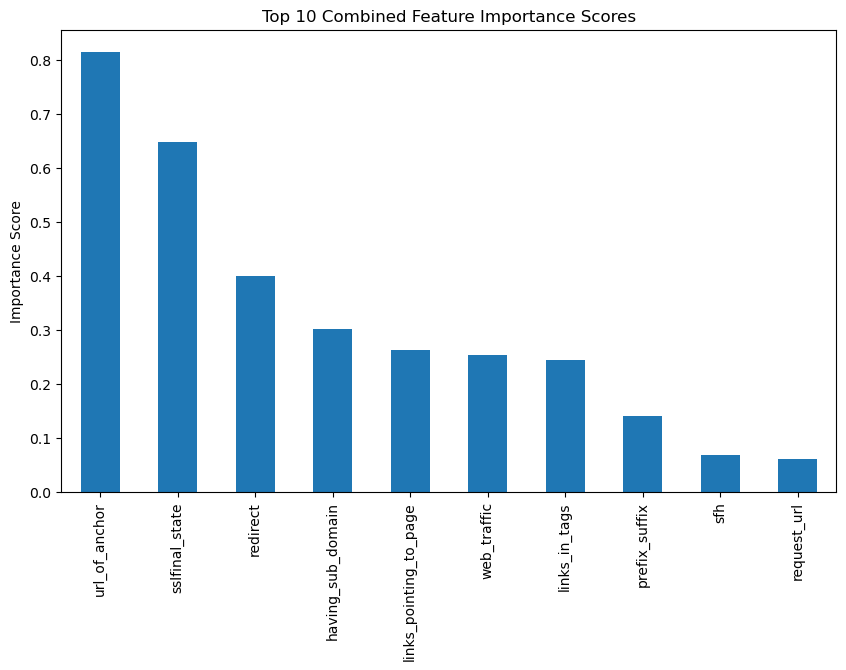

In [16]:
# 1. Combined Feature Importance + Ranking (Used for Ablation Study)

# Normalize values to 0-1 range
mi_norm = (feature_mi - feature_mi.min()) / (feature_mi.max() - feature_mi.min())
susp_norm = (suspicious_counts - suspicious_counts.min()) / (suspicious_counts.max() - suspicious_counts.min())

# Weighted score (MI slightly more important)
combined_importance = 0.6 * mi_norm + 0.4 * susp_norm
combined_importance = combined_importance.sort_values(ascending=False)

print("Top 10 Most Important Features:\n", combined_importance.head(10))

# Plot top features
combined_importance.head(10).plot(kind='bar', figsize=(10,6))
plt.title("Top 10 Combined Feature Importance Scores")
plt.ylabel("Importance Score")
plt.show()


In [17]:
# 2. Feature Ablation Study
# Description: 
# We remove the top K most important features and retrain the model.
# If performance drops -> those features are essential.


def train_and_eval_after_feature_removal(remove_features):
    """
    Retrains Model 2 after removing specified features and returns validation accuracy.
    """
    # Remove selected features
    X_train_mod = X_train.drop(columns=remove_features)
    X_val_mod = X_val.drop(columns=remove_features)
    input_size = X_train_mod.shape[1]   # <-- dynamic input size
    # Convert to tensors
    X_train_t_mod = torch.tensor(X_train_mod.values, dtype=torch.float32)
    X_val_t_mod = torch.tensor(X_val_mod.values, dtype=torch.float32)
    # Recreate model with dynamic input size
    model_mod = BetterNNClassifier(input_size=input_size)
    optimizer_mod = optim.SGD(model_mod.parameters(), lr=0.03, weight_decay=0.001)
    criterion_mod = nn.CrossEntropyLoss()
    # Train
    train_losses, val_losses, trained_model = train_with_minibatch(
        model_mod, criterion_mod, optimizer_mod,
        X_train_t_mod, y_train_t, X_val_t_mod, y_val_t,
        NUM_EPOCHS, BATCH_SIZE
    )
    # Evaluate
    trained_model.eval()
    with torch.no_grad():
        preds = torch.argmax(trained_model(X_val_t_mod), dim=1)
        acc = accuracy_score(y_val_t.numpy(), preds.numpy())
    return acc

In [18]:
# Run ablation study for top 3 features 
top3_features = combined_importance.head(3).index.tolist()

print("Testing removal of top 3 important features:", top3_features)

val_acc_after_ablation = train_and_eval_after_feature_removal(top3_features)

print(f"Validation accuracy after removing top 3 features: {val_acc_after_ablation:.4f}")

Testing removal of top 3 important features: ['url_of_anchor', 'sslfinal_state', 'redirect']

--- SGD ---

Epoch 1: train loss = 0.4247, val loss = 0.4404
Epoch 2: train loss = 0.3708, val loss = 0.3875
Epoch 3: train loss = 0.3551, val loss = 0.3735
Epoch 4: train loss = 0.3416, val loss = 0.3559
Epoch 5: train loss = 0.3272, val loss = 0.3505
Epoch 6: train loss = 0.3199, val loss = 0.3357
Epoch 7: train loss = 0.3132, val loss = 0.3344
Epoch 8: train loss = 0.3074, val loss = 0.3279
Epoch 9: train loss = 0.3003, val loss = 0.3253
Epoch 10: train loss = 0.2929, val loss = 0.3158
Epoch 11: train loss = 0.2925, val loss = 0.3138
Epoch 12: train loss = 0.2854, val loss = 0.3119
Epoch 13: train loss = 0.2852, val loss = 0.3122
Epoch 14: train loss = 0.2875, val loss = 0.3111
Epoch 15: train loss = 0.2833, val loss = 0.3080
Epoch 16: train loss = 0.2800, val loss = 0.3081
Epoch 17: train loss = 0.2781, val loss = 0.3041
Epoch 18: train loss = 0.2664, val loss = 0.2953
Epoch 19: train loss

In [19]:
# --- OPTIMIZER COMPARISON: SGD vs ADAM ---
def train_with_optimizer(opt_type):
    model_opt = BetterNNClassifier()
    
    if opt_type == "SGD":
        optimizer_opt = optim.SGD(model_opt.parameters(), lr=0.03, weight_decay=0.001)
    else:
        optimizer_opt = optim.Adam(model_opt.parameters(), lr=0.001, weight_decay=0.001)
    
    criterion_opt = nn.CrossEntropyLoss()
    
    # Pass optimizer_name so minibatch prints properly
    train_losses, val_losses, trained_model = train_with_minibatch(
        model_opt, criterion_opt, optimizer_opt,
        X_train_t, y_train_t, X_val_t, y_val_t,
        NUM_EPOCHS, BATCH_SIZE,
        optimizer_name=opt_type
    )
    
    trained_model.eval()
    with torch.no_grad():
        preds = torch.argmax(trained_model(X_val_t), dim=1)
        acc = accuracy_score(y_val_t.numpy(), preds.numpy())
    
    return acc

# --- Run training with SGD ---
acc_sgd = train_with_optimizer("SGD")

# --- Run training with Adam ---
acc_adam = train_with_optimizer("Adam")

# --- Print final accuracies ---
print(f"\nSGD Accuracy:  {acc_sgd:.4f}")
print(f"\nAdam Accuracy: {acc_adam:.4f}")



--- SGD ---

Epoch 1: train loss = 0.1993, val loss = 0.2066
Epoch 2: train loss = 0.1714, val loss = 0.1801
Epoch 3: train loss = 0.1604, val loss = 0.1728
Epoch 4: train loss = 0.1568, val loss = 0.1709
Epoch 5: train loss = 0.1470, val loss = 0.1592
Epoch 6: train loss = 0.1372, val loss = 0.1515
Epoch 7: train loss = 0.1356, val loss = 0.1494
Epoch 8: train loss = 0.1295, val loss = 0.1476
Epoch 9: train loss = 0.1280, val loss = 0.1434
Epoch 10: train loss = 0.1262, val loss = 0.1430
Epoch 11: train loss = 0.1217, val loss = 0.1377
Epoch 12: train loss = 0.1183, val loss = 0.1360
Epoch 13: train loss = 0.1173, val loss = 0.1348
Epoch 14: train loss = 0.1134, val loss = 0.1294
Epoch 15: train loss = 0.1113, val loss = 0.1335
Epoch 16: train loss = 0.1106, val loss = 0.1263
Epoch 17: train loss = 0.1082, val loss = 0.1303
Epoch 18: train loss = 0.1065, val loss = 0.1252
Epoch 19: train loss = 0.1013, val loss = 0.1217
Epoch 20: train loss = 0.1026, val loss = 0.1212
Epoch 21: train

### Error Analysis

In [22]:
# Choose which model's predictions you're analyzing:
# For Model 1:
# y_val_pred = torch.argmax(model1(X_val_t), dim=1)

# For Model 2:
y_val_pred = torch.argmax(model2(X_val_t), dim=1)

# Convert predictions to labels
y_val_pred_label = ['Safe' if x==0 else 'Phishing' for x in y_val_pred.numpy()]

# Ensure true labels list exists
y_val_label = ['Safe' if x==0 else 'Phishing' for x in y_val_t.numpy()]

# Identify misclassified indices
mis_idx = np.where(y_val_pred.numpy() != y_val_t.numpy())[0]

print(f"Total misclassified samples: {len(mis_idx)}")
error_rate = len(mis_idx) / len(X_val) * 100
print(f"Error rate = {error_rate:.4f} %")

# Display misclassified samples
if len(mis_idx) > 0:
    print("\n--- Sample Misclassified Examples ---")
    for i in mis_idx[:10]:
        print(f"\nIndex: {i}")
        print("True label:     ", y_val_label[i])
        print("Predicted label:", y_val_pred_label[i])
        print("Features:")
        display(X_val.iloc[i])


Total misclassified samples: 104
Error rate = 4.7038 %

--- Sample Misclassified Examples ---

Index: 9
True label:      Safe
Predicted label: Phishing
Features:


having_ip_address             1
url_length                   -1
shortining_service            1
having_at_symbol              1
double_slash_redirecting      1
prefix_suffix                -1
having_sub_domain             1
sslfinal_state                1
domain_registration_length   -1
favicon                       1
port                          1
https_token                   1
request_url                   1
url_of_anchor                 0
links_in_tags                 0
sfh                          -1
submitting_to_email           1
abnormal_url                  1
redirect                      0
on_mouseover                  1
rightclick                    1
popupwindow                   1
iframe                        1
age_of_domain                 1
dnsrecord                     1
web_traffic                   0
page_rank                    -1
google_index                  1
links_pointing_to_page        0
statistical_report            1
Name: 1470, dtype: int64


Index: 18
True label:      Phishing
Predicted label: Safe
Features:


having_ip_address             1
url_length                   -1
shortining_service            1
having_at_symbol              1
double_slash_redirecting      1
prefix_suffix                -1
having_sub_domain             0
sslfinal_state               -1
domain_registration_length    1
favicon                       1
port                          1
https_token                   1
request_url                   1
url_of_anchor                 0
links_in_tags                -1
sfh                          -1
submitting_to_email           1
abnormal_url                  1
redirect                      0
on_mouseover                  1
rightclick                    1
popupwindow                   1
iframe                        1
age_of_domain                -1
dnsrecord                     1
web_traffic                   1
page_rank                    -1
google_index                  1
links_pointing_to_page        0
statistical_report            1
Name: 1795, dtype: int64


Index: 21
True label:      Safe
Predicted label: Phishing
Features:


having_ip_address            -1
url_length                   -1
shortining_service            1
having_at_symbol              1
double_slash_redirecting      1
prefix_suffix                -1
having_sub_domain             0
sslfinal_state                1
domain_registration_length    1
favicon                       1
port                          1
https_token                   1
request_url                   1
url_of_anchor                 0
links_in_tags                 0
sfh                          -1
submitting_to_email           1
abnormal_url                  1
redirect                      0
on_mouseover                  1
rightclick                    1
popupwindow                   1
iframe                        1
age_of_domain                 1
dnsrecord                     1
web_traffic                   1
page_rank                    -1
google_index                  1
links_pointing_to_page        1
statistical_report            1
Name: 8613, dtype: int64


Index: 29
True label:      Phishing
Predicted label: Safe
Features:


having_ip_address             1
url_length                   -1
shortining_service            1
having_at_symbol              1
double_slash_redirecting      1
prefix_suffix                -1
having_sub_domain             0
sslfinal_state               -1
domain_registration_length   -1
favicon                       1
port                          1
https_token                   1
request_url                   1
url_of_anchor                 0
links_in_tags                 0
sfh                          -1
submitting_to_email           1
abnormal_url                  1
redirect                      0
on_mouseover                  1
rightclick                    1
popupwindow                   1
iframe                        1
age_of_domain                 1
dnsrecord                     1
web_traffic                   1
page_rank                    -1
google_index                  1
links_pointing_to_page        0
statistical_report            1
Name: 408, dtype: int64


Index: 76
True label:      Phishing
Predicted label: Safe
Features:


having_ip_address             1
url_length                   -1
shortining_service            1
having_at_symbol              1
double_slash_redirecting      1
prefix_suffix                -1
having_sub_domain             0
sslfinal_state                1
domain_registration_length   -1
favicon                       1
port                          1
https_token                   1
request_url                  -1
url_of_anchor                 0
links_in_tags                -1
sfh                          -1
submitting_to_email           1
abnormal_url                  1
redirect                      0
on_mouseover                  1
rightclick                    1
popupwindow                   1
iframe                        1
age_of_domain                -1
dnsrecord                     1
web_traffic                   1
page_rank                     1
google_index                  1
links_pointing_to_page        0
statistical_report            1
Name: 592, dtype: int64


Index: 160
True label:      Phishing
Predicted label: Safe
Features:


having_ip_address             1
url_length                   -1
shortining_service            1
having_at_symbol              1
double_slash_redirecting      1
prefix_suffix                -1
having_sub_domain            -1
sslfinal_state               -1
domain_registration_length   -1
favicon                      -1
port                         -1
https_token                   1
request_url                   1
url_of_anchor                 0
links_in_tags                -1
sfh                          -1
submitting_to_email          -1
abnormal_url                  1
redirect                      0
on_mouseover                  1
rightclick                    1
popupwindow                  -1
iframe                        1
age_of_domain                 1
dnsrecord                     1
web_traffic                   1
page_rank                    -1
google_index                 -1
links_pointing_to_page        0
statistical_report            1
Name: 1501, dtype: int64


Index: 217
True label:      Safe
Predicted label: Phishing
Features:


having_ip_address             1
url_length                   -1
shortining_service            1
having_at_symbol              1
double_slash_redirecting      1
prefix_suffix                -1
having_sub_domain             1
sslfinal_state                1
domain_registration_length    1
favicon                       1
port                          1
https_token                   1
request_url                  -1
url_of_anchor                 0
links_in_tags                -1
sfh                          -1
submitting_to_email           1
abnormal_url                  1
redirect                      0
on_mouseover                  1
rightclick                    1
popupwindow                   1
iframe                        1
age_of_domain                 1
dnsrecord                     1
web_traffic                   1
page_rank                    -1
google_index                  1
links_pointing_to_page        0
statistical_report            1
Name: 10381, dtype: int64


Index: 237
True label:      Safe
Predicted label: Phishing
Features:


having_ip_address             1
url_length                   -1
shortining_service            1
having_at_symbol              1
double_slash_redirecting      1
prefix_suffix                -1
having_sub_domain             1
sslfinal_state                1
domain_registration_length   -1
favicon                       1
port                          1
https_token                   1
request_url                   1
url_of_anchor                 0
links_in_tags                 1
sfh                          -1
submitting_to_email           1
abnormal_url                  1
redirect                      1
on_mouseover                  1
rightclick                    1
popupwindow                   1
iframe                        1
age_of_domain                -1
dnsrecord                     1
web_traffic                   0
page_rank                     1
google_index                  1
links_pointing_to_page        0
statistical_report            1
Name: 6754, dtype: int64


Index: 241
True label:      Safe
Predicted label: Phishing
Features:


having_ip_address             1
url_length                    1
shortining_service            1
having_at_symbol              1
double_slash_redirecting      1
prefix_suffix                -1
having_sub_domain            -1
sslfinal_state                0
domain_registration_length   -1
favicon                       1
port                          1
https_token                   1
request_url                   1
url_of_anchor                 1
links_in_tags                 0
sfh                          -1
submitting_to_email           1
abnormal_url                  1
redirect                      0
on_mouseover                  1
rightclick                    1
popupwindow                   1
iframe                        1
age_of_domain                 1
dnsrecord                     1
web_traffic                   1
page_rank                     1
google_index                 -1
links_pointing_to_page        0
statistical_report            1
Name: 8747, dtype: int64


Index: 245
True label:      Safe
Predicted label: Phishing
Features:


having_ip_address            -1
url_length                   -1
shortining_service            1
having_at_symbol              1
double_slash_redirecting      1
prefix_suffix                -1
having_sub_domain             1
sslfinal_state                1
domain_registration_length    1
favicon                       1
port                          1
https_token                   1
request_url                  -1
url_of_anchor                 0
links_in_tags                 0
sfh                          -1
submitting_to_email           1
abnormal_url                  1
redirect                      0
on_mouseover                  1
rightclick                    1
popupwindow                   1
iframe                        1
age_of_domain                -1
dnsrecord                     1
web_traffic                   0
page_rank                     1
google_index                  1
links_pointing_to_page        1
statistical_report            1
Name: 8046, dtype: int64

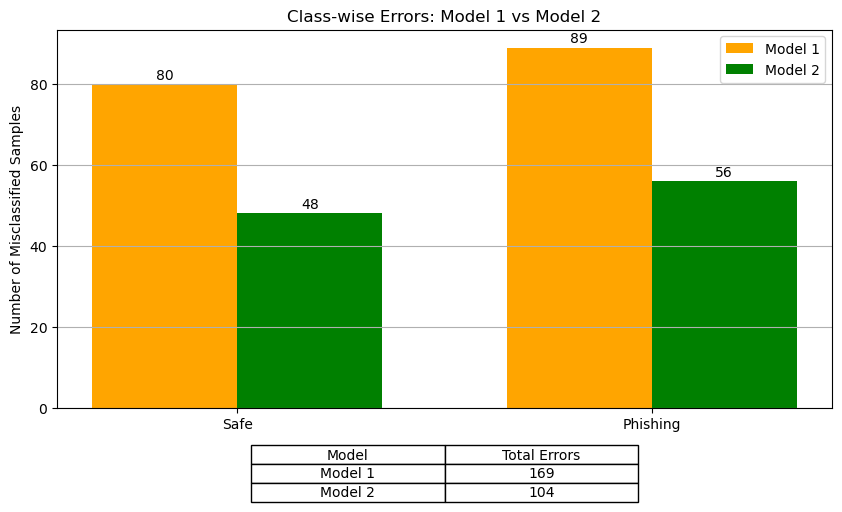

In [25]:
# ---- TRUE LABELS (shared for both models) ----
y_val_label = ['Safe' if x==0 else 'Phishing' for x in y_val_t.numpy()]

# ---- Model 1 ----
model1.eval()
with torch.no_grad():
    y_val_pred1 = torch.argmax(model1(X_val_t), dim=1)

y_val_pred_label1 = ['Safe' if x==0 else 'Phishing' for x in y_val_pred1.numpy()]

# ---- Model 2 ----
model2.eval()
with torch.no_grad():
    y_val_pred2 = torch.argmax(model2(X_val_t), dim=1)

y_val_pred_label2 = ['Safe' if x==0 else 'Phishing' for x in y_val_pred2.numpy()]

# ---------------------------------------------
# 2. Count Misclassifications Per Class
# ---------------------------------------------

classes = ['Safe', 'Phishing']

# Model 1 errors
misclassified1 = [
    true for true, pred in zip(y_val_label, y_val_pred_label1) if true != pred
]
errors_model1 = Counter(misclassified1)

# Model 2 errors
misclassified2 = [
    true for true, pred in zip(y_val_label, y_val_pred_label2) if true != pred
]
errors_model2 = Counter(misclassified2)

# Ensure both classes appear (even if 0 errors)
model1_values = [errors_model1.get(c, 0) for c in classes]
model2_values = [errors_model2.get(c, 0) for c in classes]

# Totals
total_model1 = sum(model1_values)
total_model2 = sum(model2_values)

# ---------------------------------------------
# 3. PLOT
# ---------------------------------------------
bar_width = 0.35
x = np.arange(len(classes))

plt.figure(figsize=(10,6))
bars1 = plt.bar(x - bar_width/2, model1_values, width=bar_width, label='Model 1', color='orange')
bars2 = plt.bar(x + bar_width/2, model2_values, width=bar_width, label='Model 2', color='green')

# Add labels above bars
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, int(bar.get_height()), 
             ha='center', va='bottom')

for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, int(bar.get_height()), 
             ha='center', va='bottom')

plt.xticks(x, classes)
plt.ylabel("Number of Misclassified Samples")
plt.title("Class-wise Errors: Model 1 vs Model 2")
plt.legend()
plt.grid(axis='y')

# Add table with total errors
cell_text = [
    ["Model 1", total_model1],
    ["Model 2", total_model2]
]

plt.table(
    cellText=cell_text,
    colLabels=["Model", "Total Errors"],
    loc='bottom', cellLoc='center',
    bbox=[0.25, -0.25, 0.5, 0.15]
)

plt.subplots_adjust(bottom=0.25)
plt.show()


In [24]:
# --- Comparison table ---
df_comparison = pd.DataFrame({
    "Model 1": [t1a, t1p, t1r, t1f, v1a, v1p, v1r, v1f],
    "Model 2": [t2a, t2p, t2r, t2f, v2a, v2p, v2r, v2f]
}, index=[
    "Train Accuracy", "Train Precision", "Train Recall", "Train F1-score",
    "Val Accuracy", "Val Precision", "Val Recall", "Val F1-score"
])

df_comparison

,Model 1,Model 2
Train Accuracy,0.931592,0.962573
Train Precision,0.930785,0.961460
Train Recall,0.930764,0.963084
Train F1-score,0.930775,0.962197
Val Accuracy,0.923564,0.952962
Val Precision,0.921783,0.951708
Val Recall,0.922701,0.952585
Val F1-score,0.923564,0.952133
